Step 1: accompany proof of siren initialization with visualizations

Ideas: 

create an environment with following options:

- Easily define initialization strategy
- Run visualization of activations and gradients
- Run fitting experiment

maybe, to iteratively proceed with split net init?

- [ ] Init siren
- [ ] Init cosine network
- [ ] Multiply them together

# Code init

In [1]:
import rff

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import math
from tqdm.auto import tqdm

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2, device='cpu'):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen, device=device)])
    mgrid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

import plotly.express as px
import pandas as pd

def to_np(t):
    a = t.detach().flatten().cpu().numpy()
    a = np.random.choice(a, size=1_000, replace=False)
    return a


def U(*shape, r=1):
    x = torch.rand(*shape)
    
    x = (x-0.5)*(2*r)
    return x


import lovely_tensors as lt
lt.monkey_patch()

# SIREN init story

## Single neuron story

### First neuron story

In [2]:
x = U(10_000, 2)
x

tensor[10000, 2] n=20000 x∈[-1.000, 1.000] μ=0.001 σ=0.575

In [3]:
data = []


for r in tqdm( np.linspace(1e-6, 10) ):
    W = U(2, 2048, r=r)
    h = x@W
    
    data.append({'h_std': h.std(), 'a_std': h.sin().std(), 'r': r})
    
df = pd.DataFrame(data)

  0%|          | 0/50 [00:00<?, ?it/s]

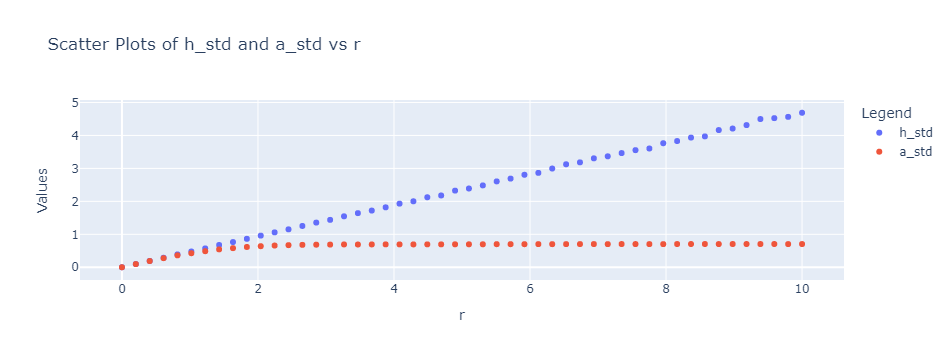

In [9]:
import plotly.graph_objs as go

# Create an empty figure
fig = go.Figure()

# Add the first scatter plot
fig.add_trace(go.Scatter(x=df['r'], y=df['h_std'],
                         mode='markers',
                         name='h_std'))

# Add the second scatter plot
fig.add_trace(go.Scatter(x=df['r'], y=df['a_std'],
                         mode='markers',
                         name='a_std'))

# Customize the layout
fig.update_layout(title='Scatter Plots of h_std and a_std vs r',
                  xaxis_title='r',
                  yaxis_title='Values',
                  legend_title='Legend')

# Show the figure
fig.show()

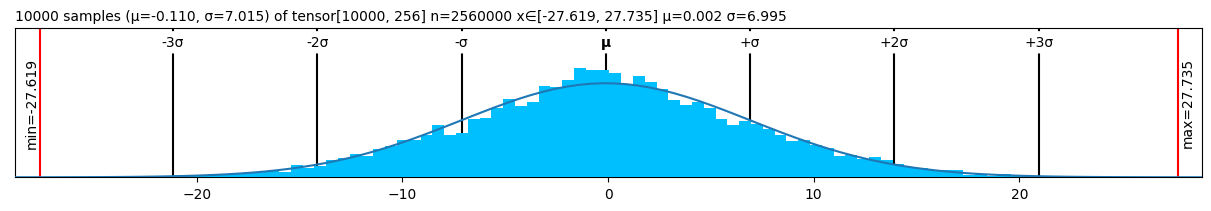

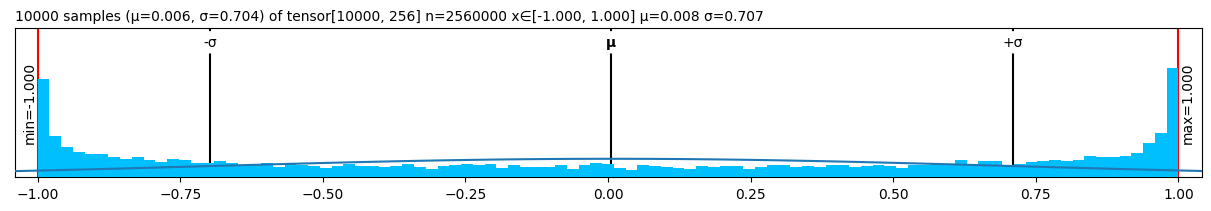

In [7]:
W = U(2, 256, r=1/2)
pre_h = 30.*(x@W)
h = pre_h.cos()

display(pre_h.plt)
display(h.plt)

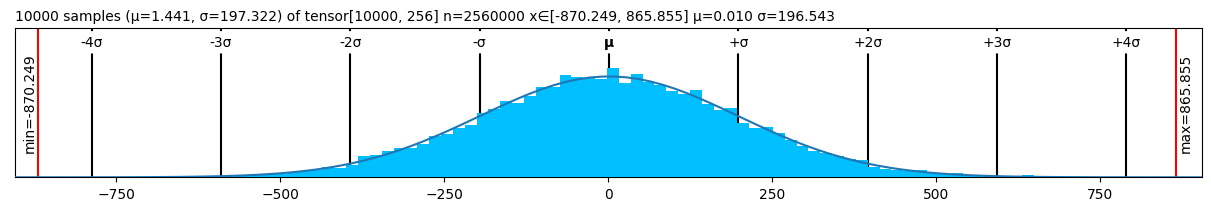

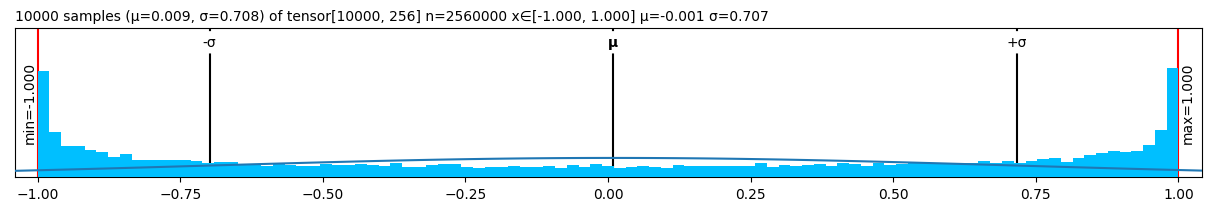

In [59]:
W = U(256, 256, r=1.)
pre_hl = 30.*(h@W)
hl = pre_hl.sin()

display (pre_hl.plt)
display (hl.plt)

In [76]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(60 / self.in_features) / self.omega_0, 
                                             np.sqrt(60 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6000 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6000 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [77]:
from collections import OrderedDict

In [78]:
img_siren = Siren(in_features=2, out_features=64, hidden_features=256, 
                  hidden_layers=6, outermost_linear=False)

In [79]:
acts = img_siren.forward_with_activations(U(5_000, 2))

input


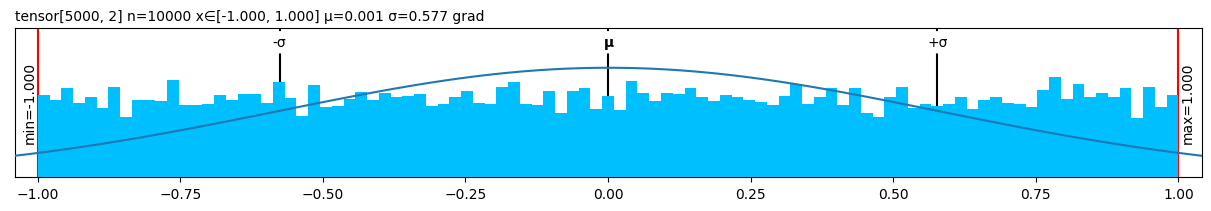

----------------------------------------------------------------------------------------------------
<class '__main__.SineLayer'>_0


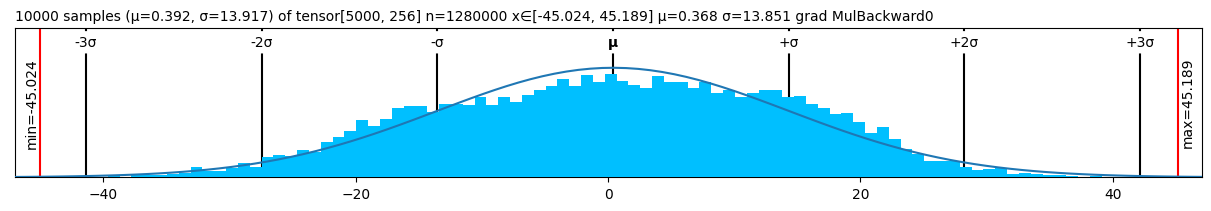

----------------------------------------------------------------------------------------------------
<class '__main__.SineLayer'>_1


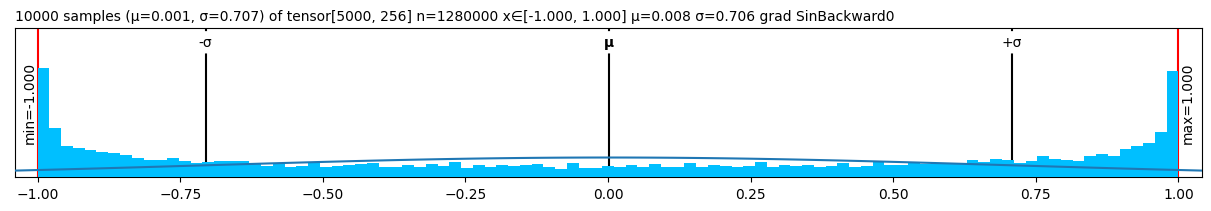

----------------------------------------------------------------------------------------------------
<class '__main__.SineLayer'>_2


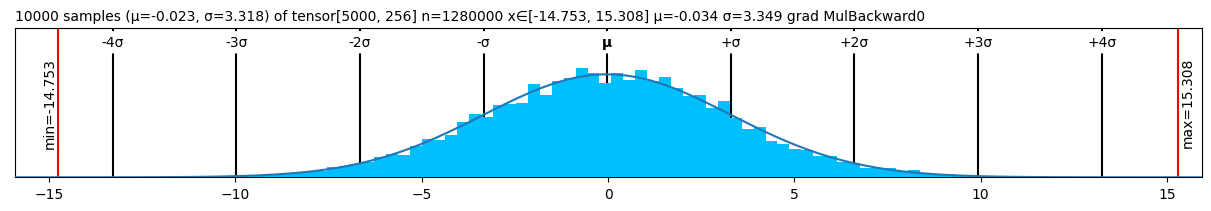

----------------------------------------------------------------------------------------------------
<class '__main__.SineLayer'>_3


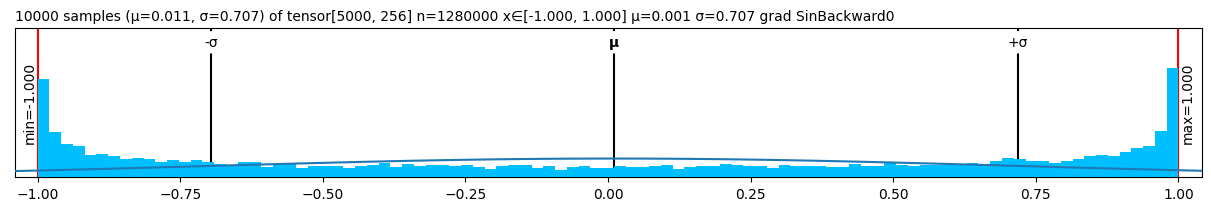

----------------------------------------------------------------------------------------------------
<class '__main__.SineLayer'>_4


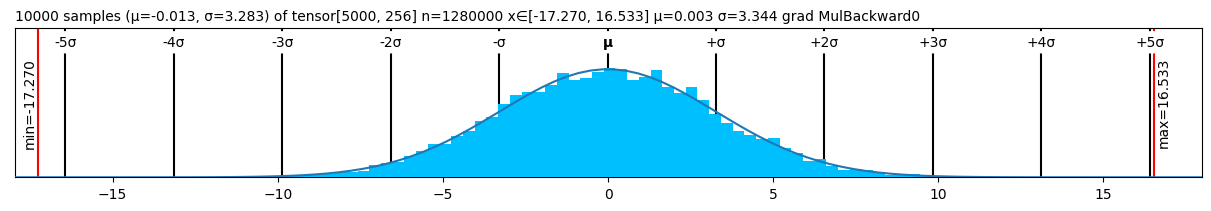

----------------------------------------------------------------------------------------------------
<class '__main__.SineLayer'>_5


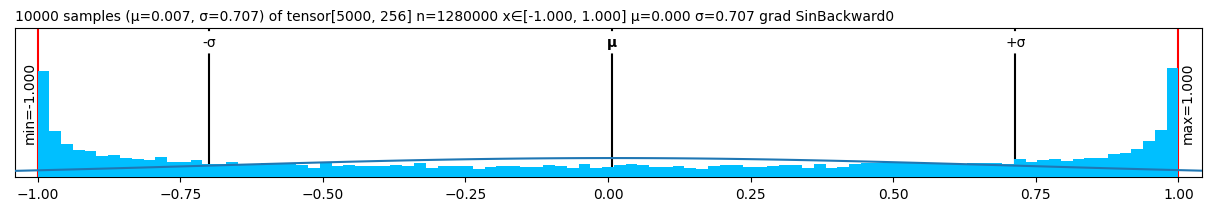

----------------------------------------------------------------------------------------------------
<class '__main__.SineLayer'>_6


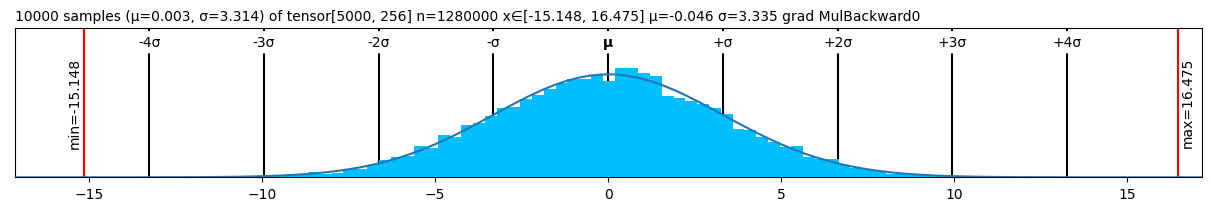

----------------------------------------------------------------------------------------------------
<class '__main__.SineLayer'>_7


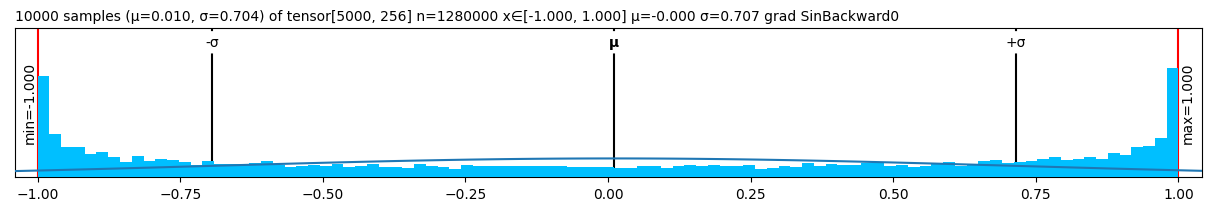

----------------------------------------------------------------------------------------------------
<class '__main__.SineLayer'>_8


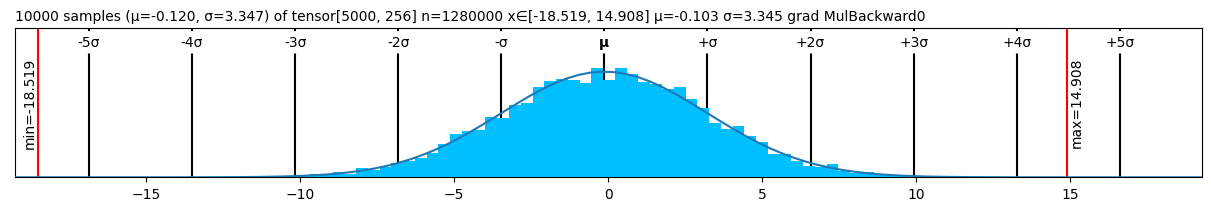

----------------------------------------------------------------------------------------------------
<class '__main__.SineLayer'>_9


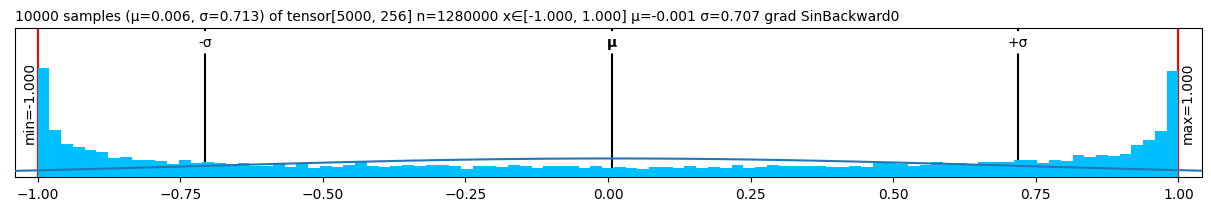

----------------------------------------------------------------------------------------------------
<class '__main__.SineLayer'>_10


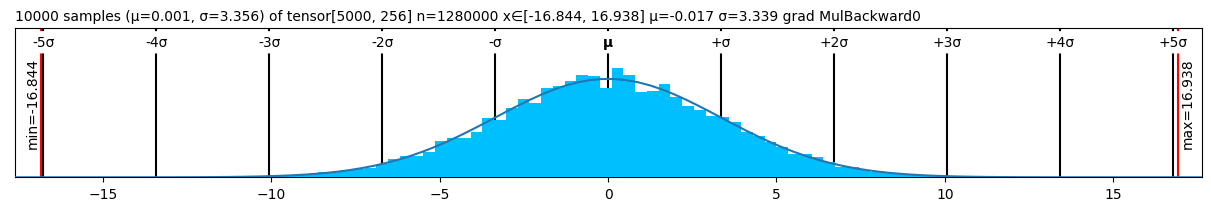

----------------------------------------------------------------------------------------------------
<class '__main__.SineLayer'>_11


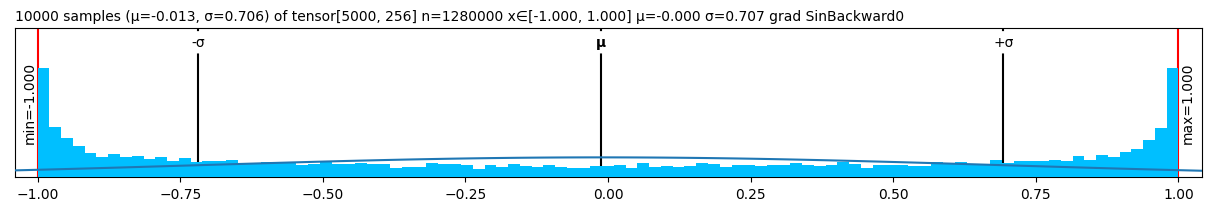

----------------------------------------------------------------------------------------------------
<class '__main__.SineLayer'>_12


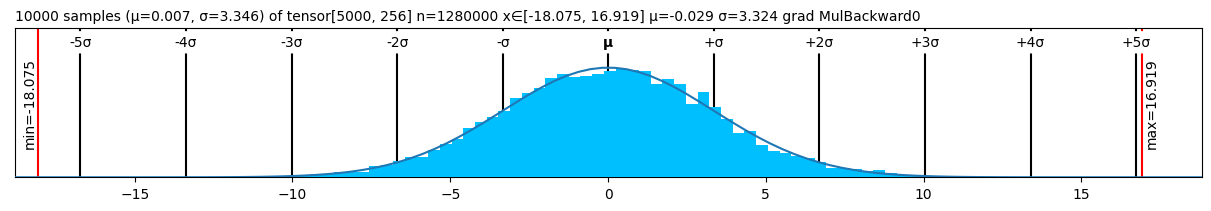

----------------------------------------------------------------------------------------------------
<class '__main__.SineLayer'>_13


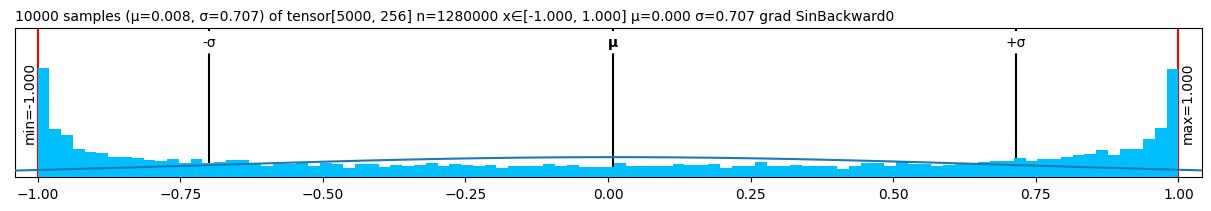

----------------------------------------------------------------------------------------------------
<class '__main__.SineLayer'>_14


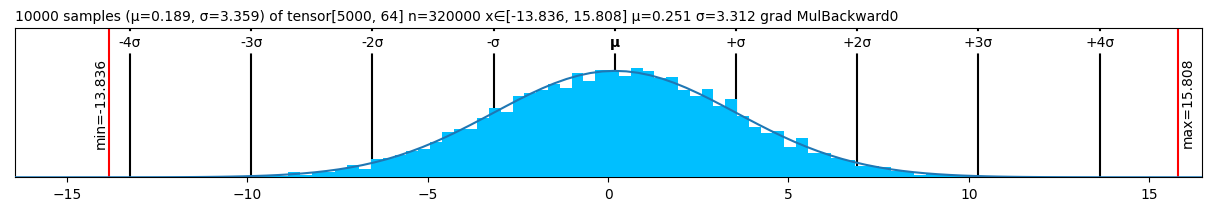

----------------------------------------------------------------------------------------------------
<class '__main__.SineLayer'>_15


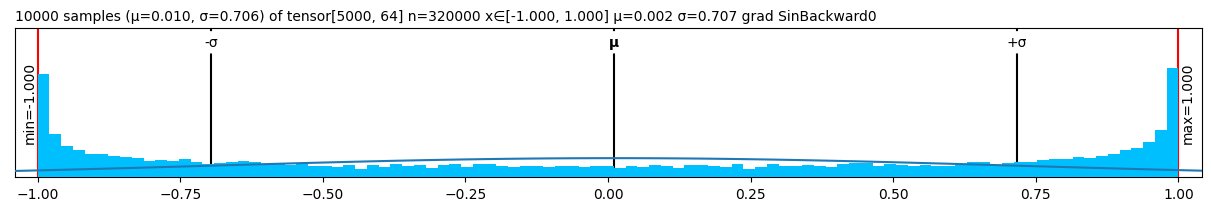

----------------------------------------------------------------------------------------------------


In [80]:
for n, a in acts.items():
    print(n)
    display(a.plt)
    print('-'*100)

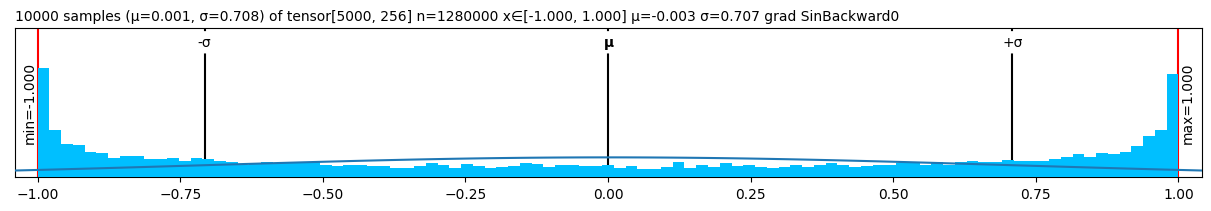

In [26]:
acts["<class '__main__.SineLayer'>_0"].sin().plt

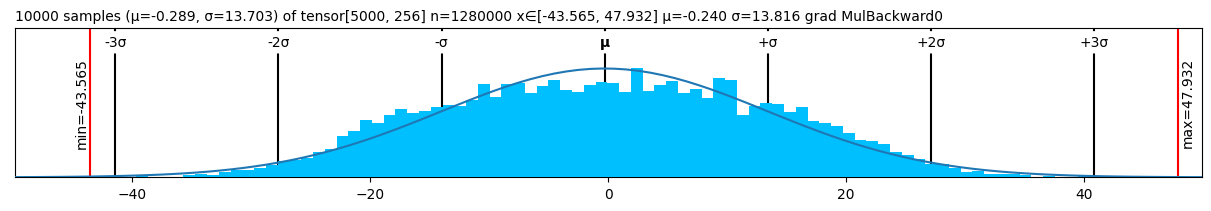

In [25]:
acts["<class '__main__.SineLayer'>_0"].plt

In [20]:
n

'input'

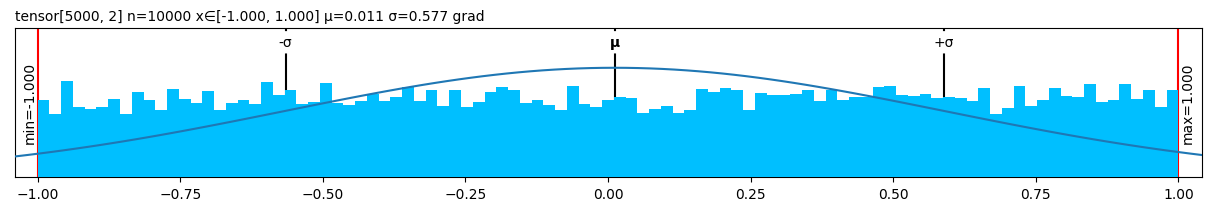

In [22]:
a.plt

In [ ]:
data = []


for r in tqdm( np.linspace(1e-6, 10) ):
    W = U(2, 2048, r=1.3)
    h = x@W
    
    data.append({'h_std': h.std(), 'a_std': h.sin().std(), 'r': r})
    
    
df = pd.DataFrame(data)

  0%|          | 0/5 [00:00<?, ?it/s]

******************************************


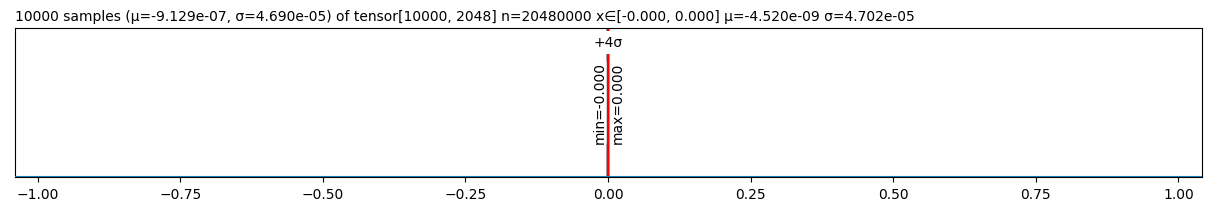

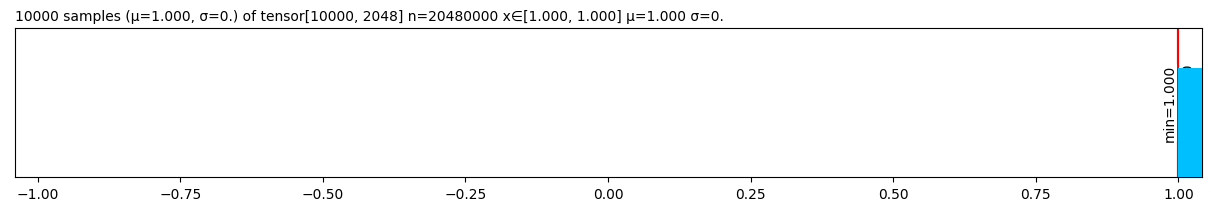

******************************************
******************************************


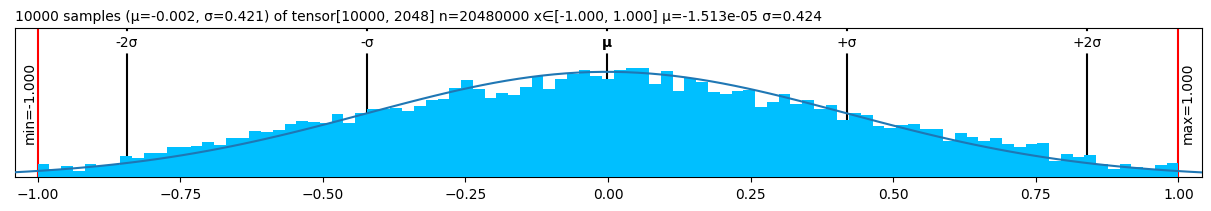

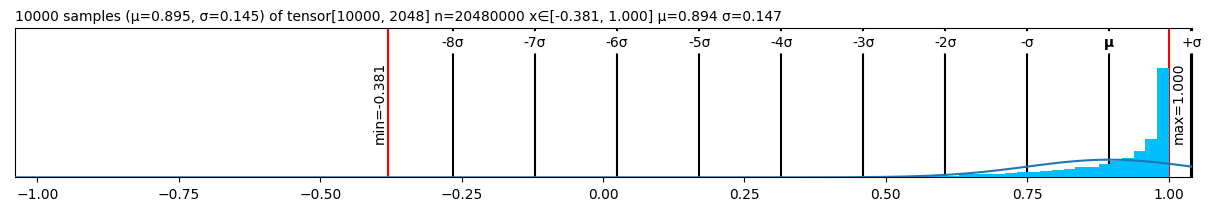

******************************************
******************************************


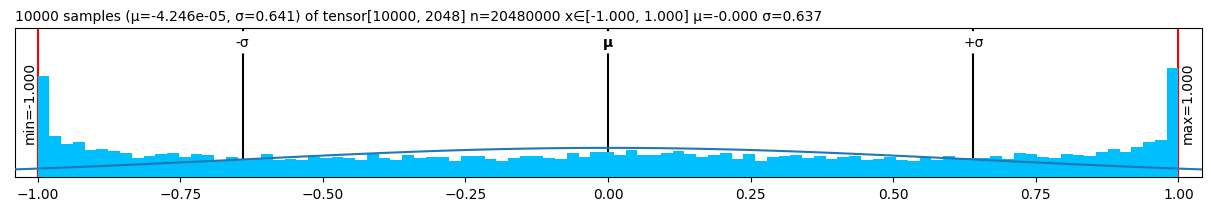

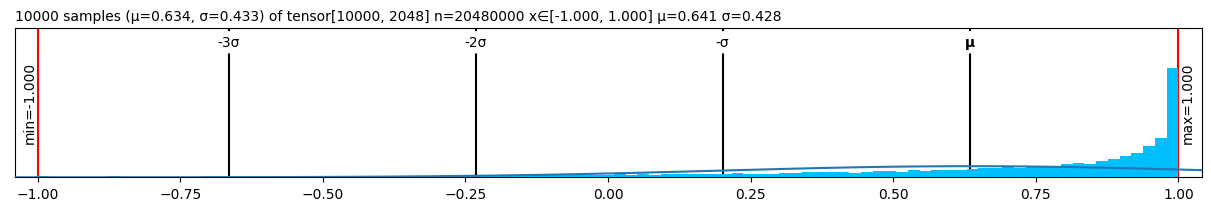

******************************************
******************************************


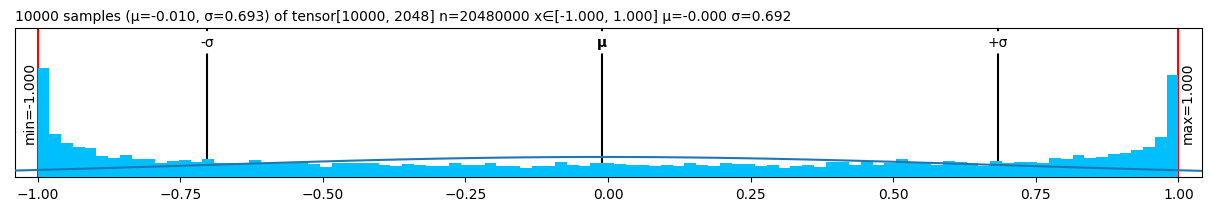

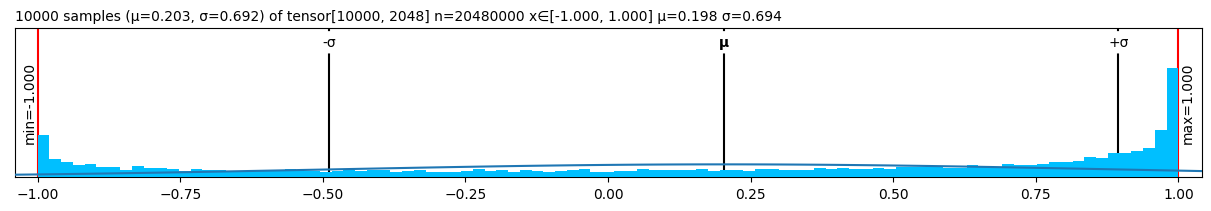

******************************************
******************************************


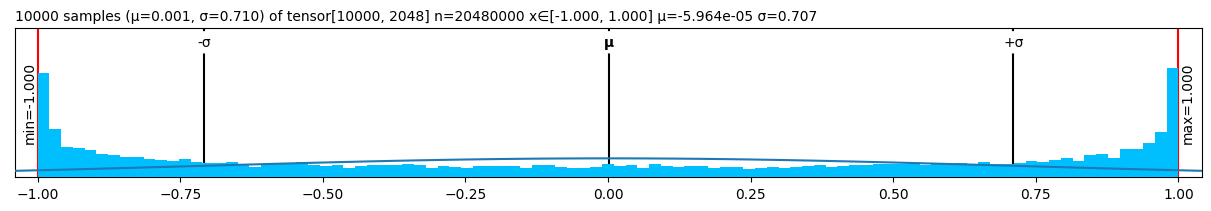

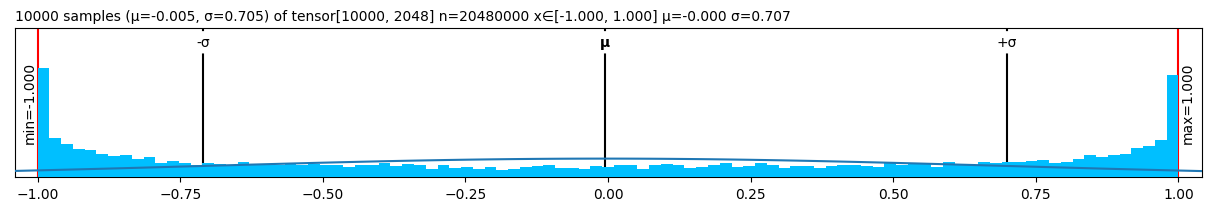

******************************************


In [64]:
for r in tqdm( [1e-4, 1, 2, 4, 10_000] ):
    W = U(2, 2048, r=r)
    h = x@W
    
    print('*'*42)
    display(h.sin().plt)
    display(h.cos().plt)
    print('*'*42)
    

### n-s neuron story

When each component of w is uniformly
distributed such as wi ∼ U(−c/√
n, c/√
n), c ∈ R, we show (see supplemental) that the dot product
converges to the normal distribution wT x ∼ N (0, c2/6) as n grows

$\sigma$

tensor[10000, 2] n=20000 x∈[-1.000, 1.000] μ=-0.004 σ=0.575

In [25]:
def first_layer_r(fan_in): return (6/fan_in)**0.5

In [48]:
ns = np.arange(2, 1024)
cs = [0.5, 2, 10, 42.42]

data = []

for n in tqdm(ns):
    for c in cs:
        r = c/((n)**0.5)
        W = U(2, 64, r=r)
        s = (x@W).std().item()
        s_pred = c**2 / 6
        data.append({'𝜎': s, 'c': c, 'n': n, 'r': r, 'type': 'actual'})
        data.append({'𝜎': s_pred, 'c': c, 'n': n, 'r': r, 'type': 'predicted'})        

  0%|          | 0/1022 [00:00<?, ?it/s]

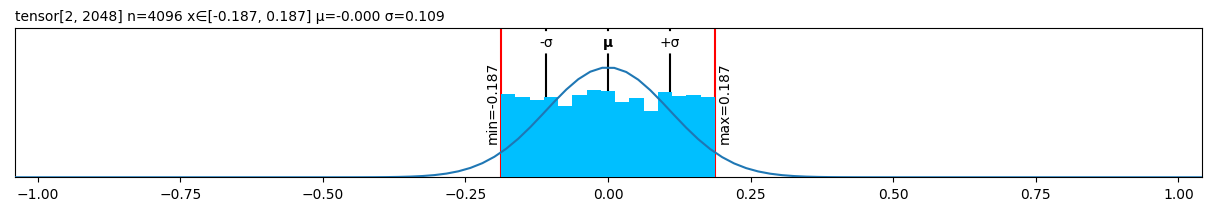

In [51]:
c = 3
n = 256
W = U(2, 2048, r=c/(n**0.5))
W.plt

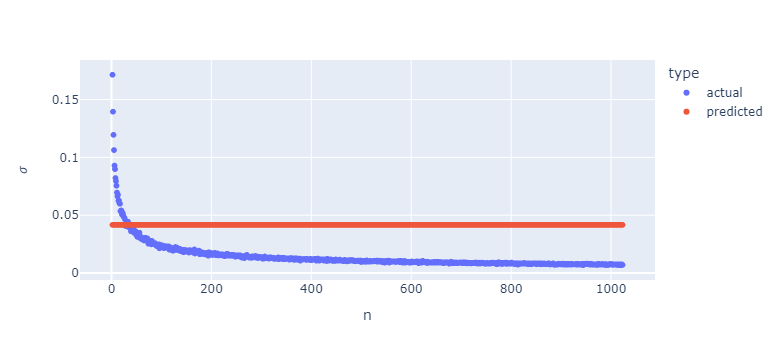

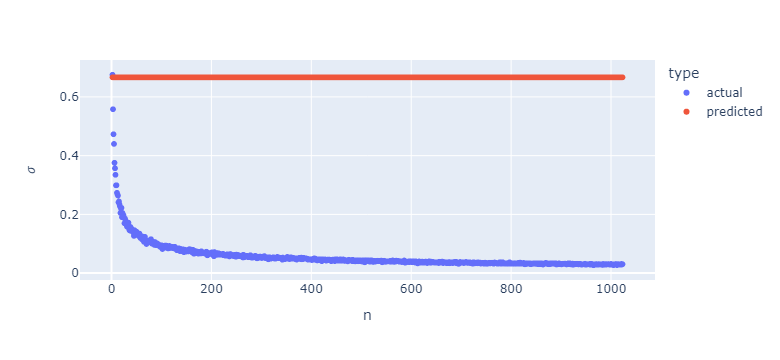

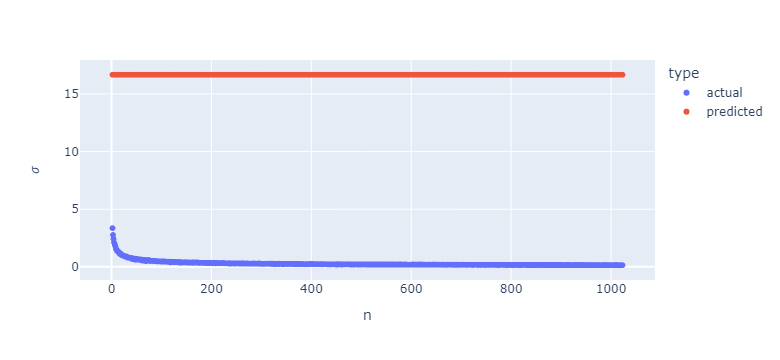

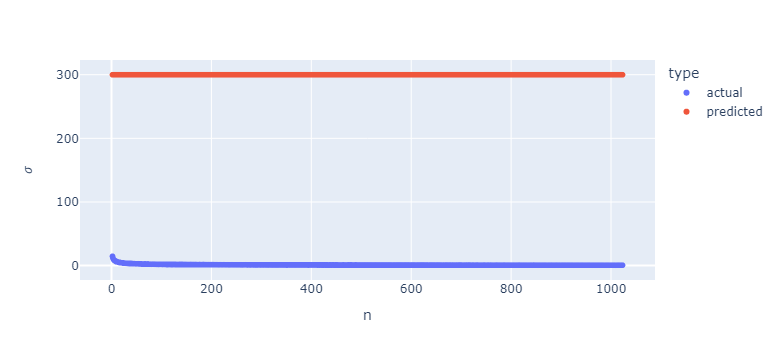

In [49]:
df = pd.DataFrame(data)


for c in cs:
    df_c = df[df['c'] == c]
    fig = px.scatter(df_c, x='n', y='𝜎', color='type')
    fig.show()

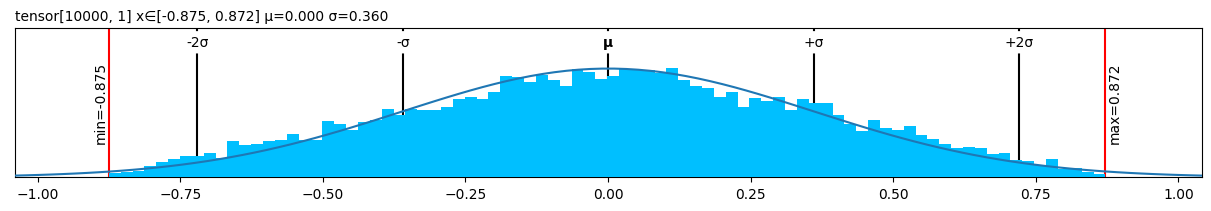

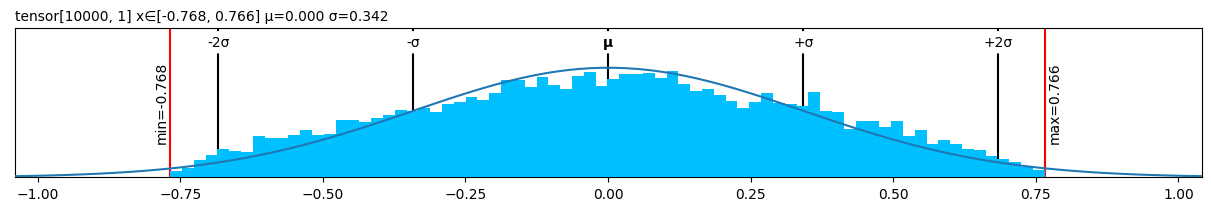

In [22]:
W = U(2, 1, r=1/2)

h = x@W
display( (h).plt )

display(h.sin().plt)

# cos(x) * sin(x) init story